In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style='whitegrid', palette='tab10', font_scale=1.2)

# Задание 5
Требуется подобрать и применить наилучший статистический метод, позволяющий ответить на вопрос прикладной задачи; обосновать выбор метода, его применимость и оптимальность. Не нужно использовать все возможные методы, нужно выбрать наиболее подходящий. Помимо выводов, касающихся математических особенностей решения, необходимо в терминах предметной области сформулировать выводы, которые могли бы быть понятны гипотетическому заказчику-нематематику.

Необходимо сдать: ipython notebook и сгенерированный по нему pdf-файл с подробным отчётом по проведённому исследованию, содержащий визуализацию исходных данных, описания и выводы каждого этапа анализа — используемые методы, обоснование их применимости, графики.

В данном задании воспользуйтесь дисперсионным анализом, либо известными вам одномерными методами статистического анализа. Не забывайте делать поправку на множественную проверку гипотез там, где это необходимо.

## Прочность промышленных вентиляторов
Измерен разрушающий крутящий момент 64 промышленных вентиляторов; для каждого известны тип отверстия, форма барабана и метод соединения (fans.txt).

Cвязан ли разрушающий крутящий момент с характеристиками вентилятора?


# Решение
Загружаем выборку:

In [2]:
df = pd.read_csv('fans.txt', sep='\t', decimal=',')
df.head()

,Тип отверстия,Метод соединения,Форма барабана,Разрушающий крутящий момент (Дж)
0,круглое,паз,гладкий,257.61
1,круглое,паз,гладкий,257.61
2,круглое,паз,гладкий,257.61
3,круглое,паз,гладкий,271.16
4,круглое,паз,гладкий,271.16


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 4 columns):
Тип отверстия                       64 non-null object
Метод соединения                    64 non-null object
Форма барабана                      64 non-null object
Разрушающий крутящий момент (Дж)    64 non-null float64
dtypes: float64(1), object(3)
memory usage: 2.1+ KB


Посмотрим на размер групп, на которые делят выборку категориальные признаки:

In [4]:
for feature in df.columns[:-1]:
    print(df[feature].value_counts())

круглое          32
шестиугольное    32
Name: Тип отверстия, dtype: int64
паз       32
резьба    32
Name: Метод соединения, dtype: int64
гофрированный    32
гладкий          32
Name: Форма барабана, dtype: int64


Пропусков нет. В выборке всего 64 объекта.

Построим боксплоты, разбивая выборку по категориальным признакам:

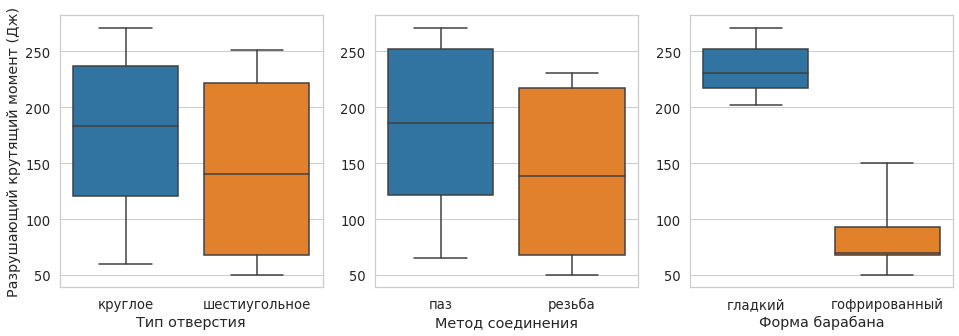

In [5]:
fig, axs = plt.subplots(ncols=3, figsize=(16, 5))
for i in range(3):
    sns.boxplot(x=df.columns[i],
                y='Разрушающий крутящий момент (Дж)',
                data=df, whis=2.5 if i == 2 else 1.5, ax=axs[i]) \
        .set(ylabel='Разрушающий крутящий момент (Дж)' if i == 0 else None)
# На боксплоте признака 'Форма барабана' все объекты одной из комбинаций категориальных 
# признаков лежат за пределами 1.5IQR и определяются как выбросы, поэтому whis=2.5

Предварительно можно сделать вывод, что на разрушающий крутящий момент больше всего влияет форма барабана.

Посмотрим на распределение разрушающего крутящего момента по всей выборке:

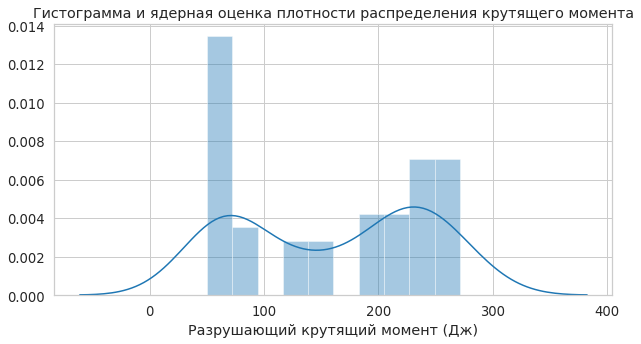

In [6]:
plt.figure(figsize=(10, 5))
sns.distplot(df['Разрушающий крутящий момент (Дж)'], bins=10)
plt.title('Гистограмма и ядерная оценка плотности распределения крутящего момента');

Не похоже на нормальное распределение. Но на сам деле нам надо проверить нормальность подвыборок, которые мы будем сравнивать.

Теперь построим гистограммы и оценку плотности крутящего момента разбивая выборку по категориальным признакам:

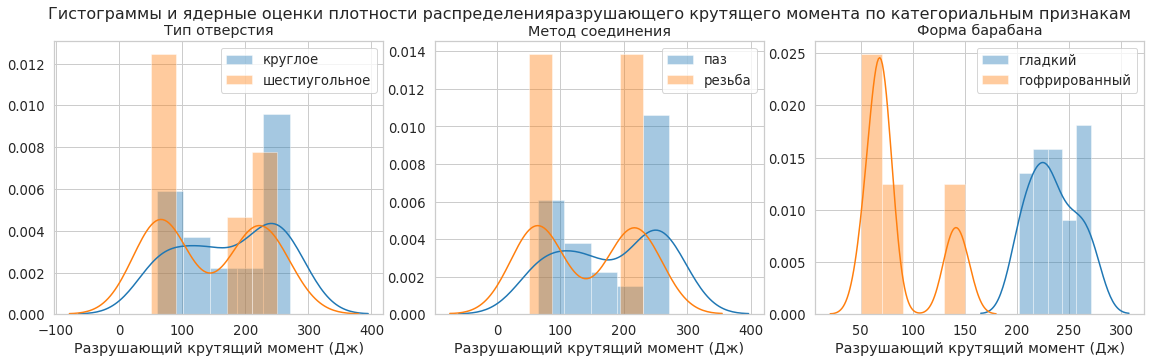

In [7]:
fig, axs = plt.subplots(ncols=3, figsize=(16, 5))
fig.suptitle('Гистограммы и ядерные оценки плотности распределения ' +
             'разрушающего крутящего момента по категориальным признакам', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.93])


for i in range(3):
    unique_values = df[df.columns[i]].unique()
    for j in range(2):
        sns.distplot(df[df[df.columns[i]] == unique_values[j]]
                     ['Разрушающий крутящий момент (Дж)'],
                     bins=5, label=unique_values[j], ax=axs[i]);
        axs[i].set_title(df.columns[i])
        axs[i].legend()

Построим Q-Q plot'ы разбивая выборку по категориальным признакам, чтобы еще раз удостовериться, что распределения не нормальные:

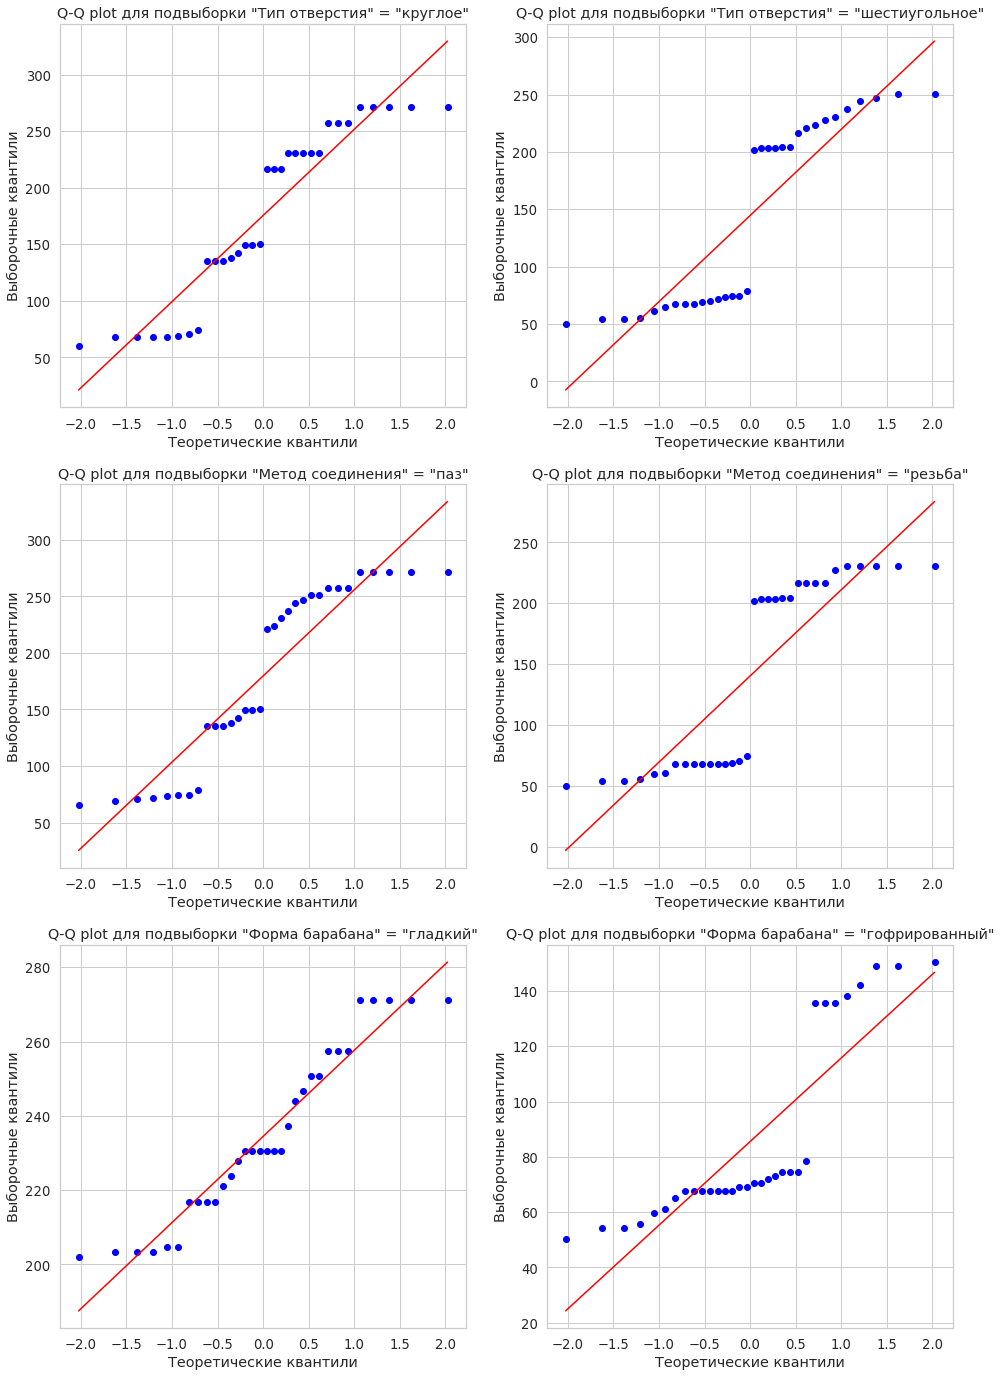

In [8]:
fig = plt.figure(figsize=(16, 24))

for i in range(3):
    unique_values = df[df.columns[i]].unique()
    for j in range(2):
        ax = plt.subplot(3, 2, 2*i+j+1)
        sps.probplot(df[df[df.columns[i]] == unique_values[j]]
                     ['Разрушающий крутящий момент (Дж)'],
                     dist='norm', plot=ax);
        ax.set_title(
            f'Q-Q plot для подвыборки "{df.columns[i]}" = "{unique_values[j]}"')
        ax.set_xlabel('Теоретические квантили')
        ax.set_ylabel('Выборочные квантили')
    

Проверим нормальность подвыборок, используя критерий Шапиро.

Обработаем результаты с помощью процедуры множественной проверки гипотез.

In [9]:
from statsmodels.sandbox.stats.multicomp import multipletests

shapiro_p_values = np.zeros((3, 2))
subsets_names = []

for i in range(3):
    unique_values = df[df.columns[i]].unique()
    for j in range(2):
        shapiro_p_values[i, j] = sps.shapiro(
            df[df[df.columns[i]] == unique_values[j]]
            ['Разрушающий крутящий момент (Дж)'])[1]
        subsets_names.append(f'{df.columns[i]} = {unique_values[j]}')

shapiro_rejects, shapiro_p_values_corrected = multipletests(
    shapiro_p_values.ravel())[:2]

shapiro_p_values_df = pd.DataFrame(
    {'Subset': subsets_names,
     'Shapiro p-value': shapiro_p_values.ravel(),
     'Corrected Shapiro p-value': shapiro_p_values_corrected,
     'Rejected': shapiro_rejects})

shapiro_p_values_df

,Subset,Shapiro p-value,Corrected Shapiro p-value,Rejected
0,Тип отверстия = круглое,0.000930,0.001860,True
1,Тип отверстия = шестиугольное,0.000014,0.000057,True
2,Метод соединения = паз,0.000323,0.000970,True
3,Метод соединения = резьба,0.000003,0.000015,True
4,Форма барабана = гладкий,0.018572,0.018572,True
5,Форма барабана = гофрированный,0.000002,0.000015,True


По Q-Q plot'ам, оценкам плотности распределения и гистограммам видно, что распределения не похожи на нормальные. Процедура МПГ с критерием Шапиро также отвергла гипотезы о нормальности распределений.

И, кроме этого, данных очень мало. Поэтому будем использовать непараметрический критерий Манна-Уитни для проверки гипотез о равненстве средних в подвыборках, разбитых по категориальным признакам. Сделаем поправку на множественную проверку гипотез.

In [10]:
mannwhitney_p_values = np.zeros(3)

for i in range(3):
    unique_values = df[df.columns[i]].unique()
    mannwhitney_p_values[i] = sps.mannwhitneyu(
        df[df[df.columns[i]] == unique_values[0]]['Разрушающий крутящий момент (Дж)'],
        df[df[df.columns[i]] == unique_values[1]]['Разрушающий крутящий момент (Дж)'],
        alternative='two-sided')[1]

mannwhitney_rejects, mannwhitney_p_values_corrected = multipletests(
    mannwhitney_p_values)[:2]

mannwhitney_p_values_df = pd.DataFrame(
    {'Feature': df.columns[:-1],
     'Mann-Whitney p-value': mannwhitney_p_values,
     'Corrected Mann-Whitney p-value': mannwhitney_p_values_corrected,
     'Rejected': mannwhitney_rejects})

mannwhitney_p_values_df

,Feature,Mann-Whitney p-value,Corrected Mann-Whitney p-value,Rejected
0,Тип отверстия,6.063310e-02,6.063310e-02,False
1,Метод соединения,2.590048e-03,5.173388e-03,True
2,Форма барабана,6.016463e-12,1.804923e-11,True


Посчитаем разность средних для пар подвыборок, в которых отвергнута гипотеза о равенстве средних:

In [11]:
print('Разность средних разрушающих крутящих моментов для разных форм барабана:',
      round(df[df['Форма барабана'] == 'гладкий'][df.columns[-1]].mean() -
            df[df['Форма барабана'] == 'гофрированный'][df.columns[-1]].mean(), 1),
      'Дж')

print('Разность средних разрушающих крутящих моментов для разных методов соединения:',
      round(df[df['Метод соединения'] == 'паз'][df.columns[-1]].mean() -
            df[df['Метод соединения'] == 'резьба'][df.columns[-1]].mean(), 1),
      'Дж')

Разность средних разрушающих крутящих моментов для разных форм барабана: 148.9 Дж
Разность средних разрушающих крутящих моментов для разных методов соединения: 39.2 Дж


## Вывод:
На разрушающий крутящий момент влияет форма барабана и метод соединения, а тип отверстия нет.

В среднем:
- вентилятор с гладким барабаном выдерживает крутящий момент на 148.9 Дж больше, чем с гофрированным барабаном.
- вентилятор с пазовым соединением выдерживает крутящий момент на 39.2 Дж больше, чем с резьбовым соединением.